# SSVEP 腦波分析流程
## Steady-State Visual Evoked Potential 穩態視覺誘發電位

---

## 課程大綱
1. SSVEP 原理介紹
2. 數據載入與視覺化
3. 訊號預處理
4. 特徵提取
5. 分類與辨識
6. 結果評估

---

## 1. SSVEP 原理簡介

**什麼是SSVEP？**
- 當我們看著特定頻率閃爍的光源時，大腦視覺區會產生相同頻率的電位反應
- 例如：看著10Hz閃爍的燈光 → 腦波中會出現10Hz的訊號
- 應用：腦機介面拼字器、輪椅控制等

**常見刺激頻率：**
- 8Hz, 10Hz, 12Hz, 15Hz 等
- 通常使用數個不同頻率作為控制指令


In [4]:
# 安裝必要套件
# !pip install mne numpy scipy matplotlib scikit-learn pandas seaborn

In [ ]:
# 導入所需函式庫
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.fft import fft, fftfreq
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# 設定繪圖風格
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("所有套件載入完成！")

✅ 所有套件載入完成！


## 2. 產生模擬SSVEP數據

我們先產生模擬的SSVEP訊號

In [6]:
# 實驗參數設定
sampling_rate = 250  # 取樣頻率 (Hz)
duration = 4  # 每個trial的時間長度 (秒)
n_trials = 40  # 每個頻率的trial數量
n_channels = 8  # EEG通道數

# SSVEP 刺激頻率
target_freqs = [8, 10, 12, 15]  # Hz
n_classes = len(target_freqs)

print(f"實驗設定：")
print(f"  - 取樣頻率: {sampling_rate} Hz")
print(f"  - Trial長度: {duration} 秒")
print(f"  - 每類別Trial數: {n_trials}")
print(f"  - 刺激頻率: {target_freqs} Hz")
print(f"  - 總共數據: {n_trials * n_classes} trials")

實驗設定：
  - 取樣頻率: 250 Hz
  - Trial長度: 4 秒
  - 每類別Trial數: 40
  - 刺激頻率: [8, 10, 12, 15] Hz
  - 總共數據: 160 trials


In [ ]:
def generate_ssvep_signal(freq, sampling_rate, duration, n_channels=8, snr=0.5):
    """
    產生模擬SSVEP訊號
    
    參數:
        freq: 目標頻率
        sampling_rate: 取樣頻率
        duration: 訊號長度(秒)
        n_channels: 通道數
        snr: 訊噪比 (0-1之間，越大訊號越乾淨)
    """
    n_samples = int(sampling_rate * duration)
    t = np.linspace(0, duration, n_samples)
    
    # 產生多通道訊號
    signal_data = np.zeros((n_channels, n_samples))
    
    for ch in range(n_channels):
        # 基礎SSVEP訊號 (基頻 + 二次諧波)
        ssvep = (snr * np.sin(2 * np.pi * freq * t + np.random.rand()) + 
                 snr * 0.3 * np.sin(2 * np.pi * 2 * freq * t + np.random.rand()))
        
        # 加入背景腦波 (alpha波 8-13Hz, beta波 13-30Hz)
        alpha = 0.3 * np.sin(2 * np.pi * (9 + np.random.rand()) * t)
        beta = 0.2 * np.sin(2 * np.pi * (20 + 5*np.random.rand()) * t)
        
        # 雜訊
        noise = (1 - snr) * np.random.randn(n_samples) * 0.5
        
        # 組合訊號
        signal_data[ch] = ssvep + alpha + beta + noise
        
        # 後端通道訊號較強 (模擬視覺皮層位置)
        if ch >= n_channels - 3:
            signal_data[ch] *= 1.5
    
    return signal_data

# 產生所有數據
X_data = []
y_labels = []

for class_idx, freq in enumerate(target_freqs):
    for trial in range(n_trials):
        signal_data = generate_ssvep_signal(freq, sampling_rate, duration, n_channels)
        X_data.append(signal_data)
        y_labels.append(class_idx)

X_data = np.array(X_data)  # shape: (n_trials_total, n_channels, n_samples)
y_labels = np.array(y_labels)

print(f"\n 數據產生完成！")
print(f"   數據形狀: {X_data.shape}")
print(f"   標籤形狀: {y_labels.shape}")


✅ 數據產生完成！
   數據形狀: (160, 8, 1000)
   標籤形狀: (160,)


## 3. 數據視覺化

讓我們看看SSVEP訊號長什麼樣子

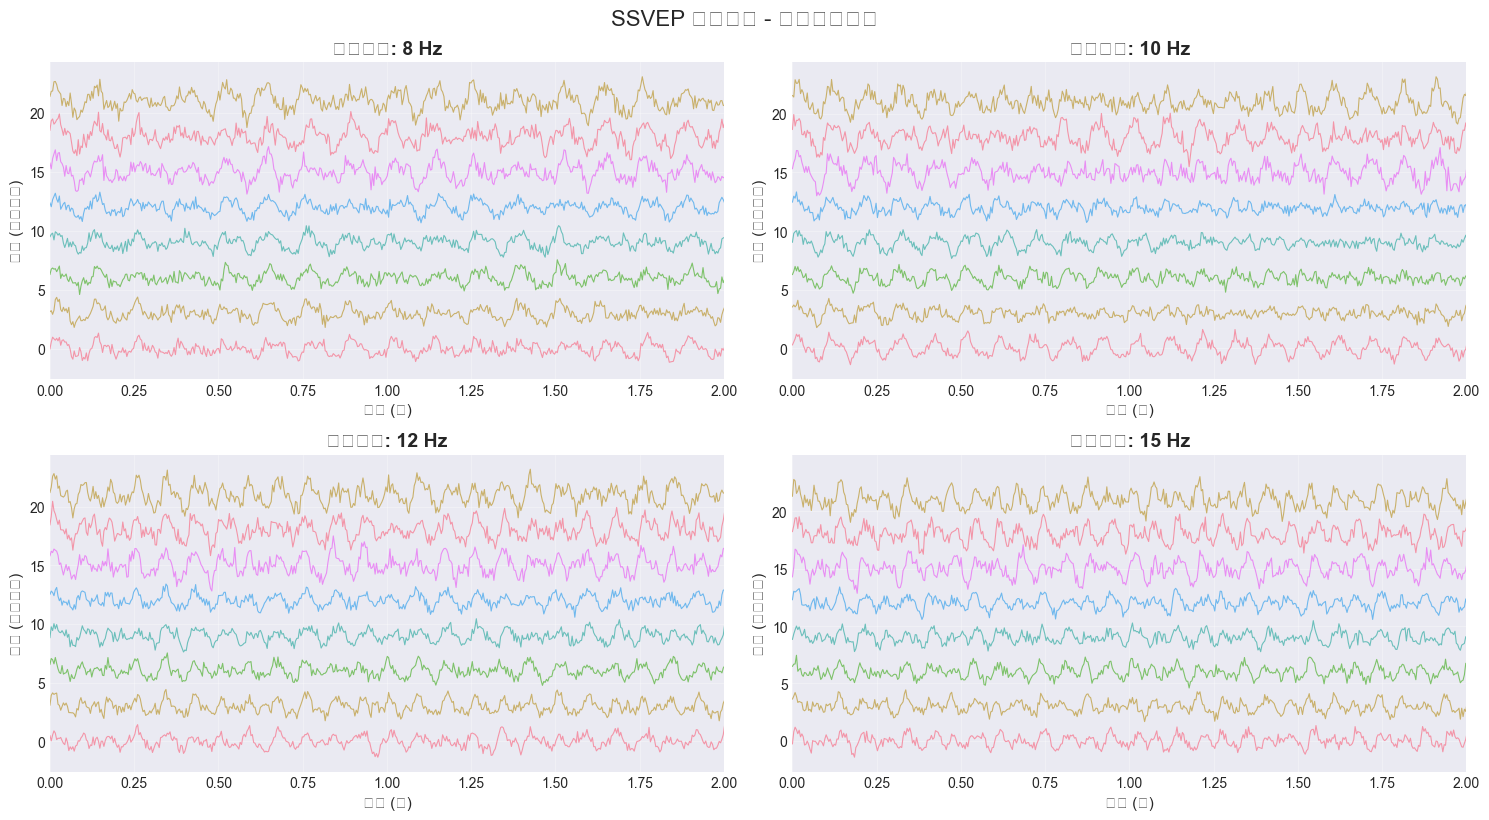

In [8]:
# 繪製不同頻率的原始訊號
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
axes = axes.flatten()

time_axis = np.linspace(0, duration, X_data.shape[2])

for idx, freq in enumerate(target_freqs):
    # 取得該頻率的第一個trial
    trial_data = X_data[idx * n_trials]  # shape: (n_channels, n_samples)
    
    # 繪製所有通道
    for ch in range(n_channels):
        axes[idx].plot(time_axis, trial_data[ch] + ch*3, alpha=0.7, linewidth=0.8)
    
    axes[idx].set_title(f'刺激頻率: {freq} Hz', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('時間 (秒)', fontsize=11)
    axes[idx].set_ylabel('通道 (偏移顯示)', fontsize=11)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlim([0, 2])  # 只顯示前2秒

plt.tight_layout()
plt.suptitle('SSVEP 原始訊號 - 不同刺激頻率', fontsize=16, y=1.02)
plt.show()

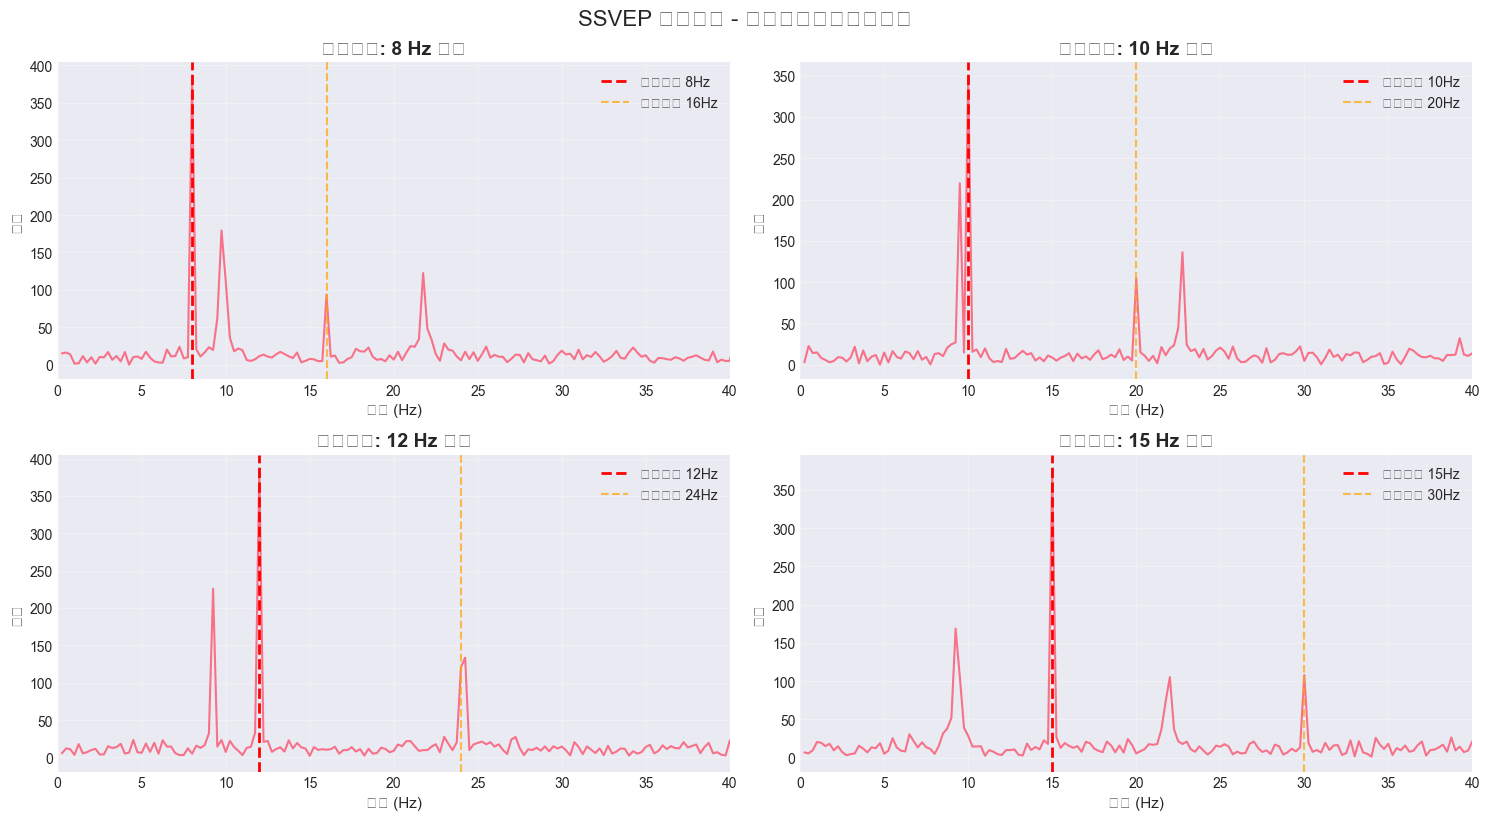

In [9]:
# 頻譜分析 - 看看頻域特徵
def plot_spectrum(signal_data, sampling_rate, freq_label):
    """計算並繪製功率頻譜"""
    # 使用後端通道 (視覺皮層)
    channel_data = signal_data[-1]  # 最後一個通道
    
    # FFT
    n = len(channel_data)
    fft_vals = fft(channel_data)
    fft_freq = fftfreq(n, 1/sampling_rate)
    
    # 只取正頻率
    positive_freq_idx = fft_freq > 0
    fft_freq = fft_freq[positive_freq_idx]
    fft_power = np.abs(fft_vals[positive_freq_idx])
    
    return fft_freq, fft_power

# 繪製頻譜
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
axes = axes.flatten()

for idx, freq in enumerate(target_freqs):
    trial_data = X_data[idx * n_trials]
    fft_freq, fft_power = plot_spectrum(trial_data, sampling_rate, freq)
    
    axes[idx].plot(fft_freq, fft_power, linewidth=1.5)
    axes[idx].axvline(freq, color='red', linestyle='--', linewidth=2, 
                     label=f'目標頻率 {freq}Hz')
    axes[idx].axvline(freq*2, color='orange', linestyle='--', linewidth=1.5, 
                     label=f'二次諧波 {freq*2}Hz', alpha=0.7)
    
    axes[idx].set_xlim([0, 40])
    axes[idx].set_title(f'頻譜分析: {freq} Hz 刺激', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('頻率 (Hz)', fontsize=11)
    axes[idx].set_ylabel('功率', fontsize=11)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('SSVEP 頻譜分析 - 可以明顯看到目標頻率', fontsize=16, y=1.02)
plt.show()

## 4. 訊號預處理

預處理步驟:
1. 帶通濾波 (5-40Hz) - 保留SSVEP相關頻段
2. 去除基線漂移
3. 標準化

In [10]:
def preprocess_signal(data, sampling_rate, lowcut=5, highcut=40):
    """
    預處理SSVEP訊號
    
    參數:
        data: 輸入訊號 (n_channels, n_samples)
        sampling_rate: 取樣頻率
        lowcut: 低頻截止
        highcut: 高頻截止
    """
    # 設計帶通濾波器
    nyquist = sampling_rate / 2
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(4, [low, high], btype='band')
    
    # 對每個通道進行濾波
    filtered_data = np.zeros_like(data)
    for ch in range(data.shape[0]):
        filtered_data[ch] = signal.filtfilt(b, a, data[ch])
    
    # 標準化 (每個通道)
    for ch in range(filtered_data.shape[0]):
        filtered_data[ch] = (filtered_data[ch] - np.mean(filtered_data[ch])) / np.std(filtered_data[ch])
    
    return filtered_data

# 預處理所有數據
X_preprocessed = np.array([preprocess_signal(trial, sampling_rate) for trial in X_data])

print(f"✅ 預處理完成！")
print(f"   處理後數據形狀: {X_preprocessed.shape}")

✅ 預處理完成！
   處理後數據形狀: (160, 8, 1000)


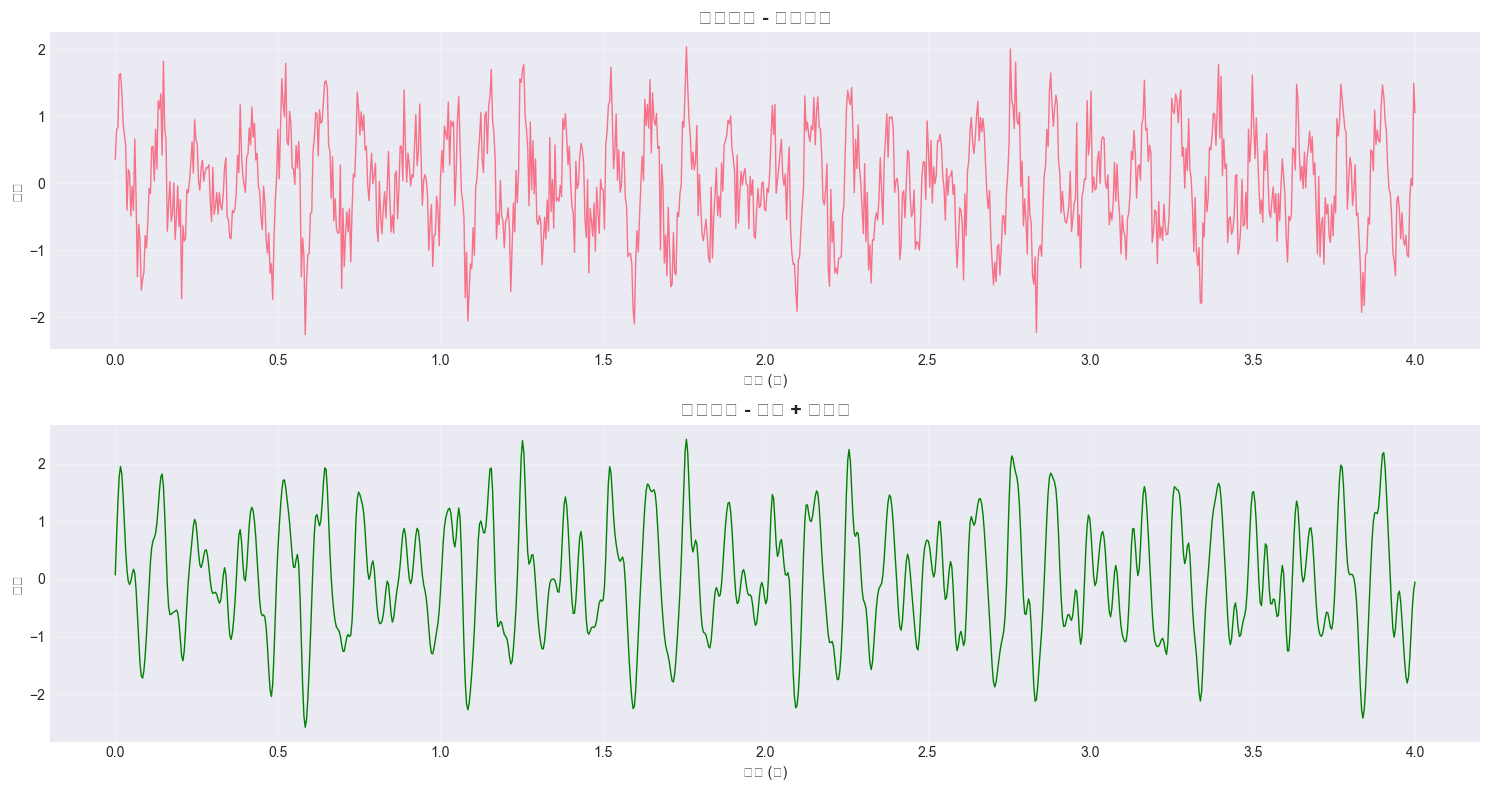

In [11]:
# 比較預處理前後的訊號
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

sample_trial = 0
sample_channel = -1  # 最後一個通道
time_axis = np.linspace(0, duration, X_data.shape[2])

# 原始訊號
axes[0].plot(time_axis, X_data[sample_trial, sample_channel], linewidth=1)
axes[0].set_title('預處理前 - 原始訊號', fontsize=14, fontweight='bold')
axes[0].set_xlabel('時間 (秒)')
axes[0].set_ylabel('振幅')
axes[0].grid(True, alpha=0.3)

# 預處理後訊號
axes[1].plot(time_axis, X_preprocessed[sample_trial, sample_channel], linewidth=1, color='green')
axes[1].set_title('預處理後 - 濾波 + 標準化', fontsize=14, fontweight='bold')
axes[1].set_xlabel('時間 (秒)')
axes[1].set_ylabel('振幅')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. 特徵提取

我們使用 **功率譜密度 (Power Spectral Density, PSD)** 作為特徵

方法: 計算每個目標頻率及其諧波的功率

In [12]:
def extract_features(signal_data, sampling_rate, target_freqs, n_harmonics=2):
    """
    提取SSVEP特徵
    
    參數:
        signal_data: 訊號 (n_channels, n_samples)
        sampling_rate: 取樣頻率
        target_freqs: 目標頻率列表
        n_harmonics: 使用的諧波數量
    
    回傳:
        features: 特徵向量
    """
    features = []
    
    # 對每個通道計算PSD
    for ch in range(signal_data.shape[0]):
        # 計算功率譜密度
        freqs, psd = signal.welch(signal_data[ch], sampling_rate, nperseg=sampling_rate*2)
        
        # 對每個目標頻率
        for target_freq in target_freqs:
            # 基頻和諧波的功率
            for harmonic in range(1, n_harmonics + 1):
                freq_of_interest = target_freq * harmonic
                
                # 找到最接近的頻率索引
                idx = np.argmin(np.abs(freqs - freq_of_interest))
                
                # 取該頻率附近的平均功率 (±0.5Hz)
                freq_band = (freqs >= freq_of_interest - 0.5) & (freqs <= freq_of_interest + 0.5)
                power = np.mean(psd[freq_band])
                
                features.append(power)
    
    return np.array(features)

# 提取所有trial的特徵
X_features = np.array([extract_features(trial, sampling_rate, target_freqs) 
                       for trial in X_preprocessed])

print(f"✅ 特徵提取完成！")
print(f"   特徵矩陣形狀: {X_features.shape}")
print(f"   每個trial的特徵數: {X_features.shape[1]}")

✅ 特徵提取完成！
   特徵矩陣形狀: (160, 64)
   每個trial的特徵數: 64


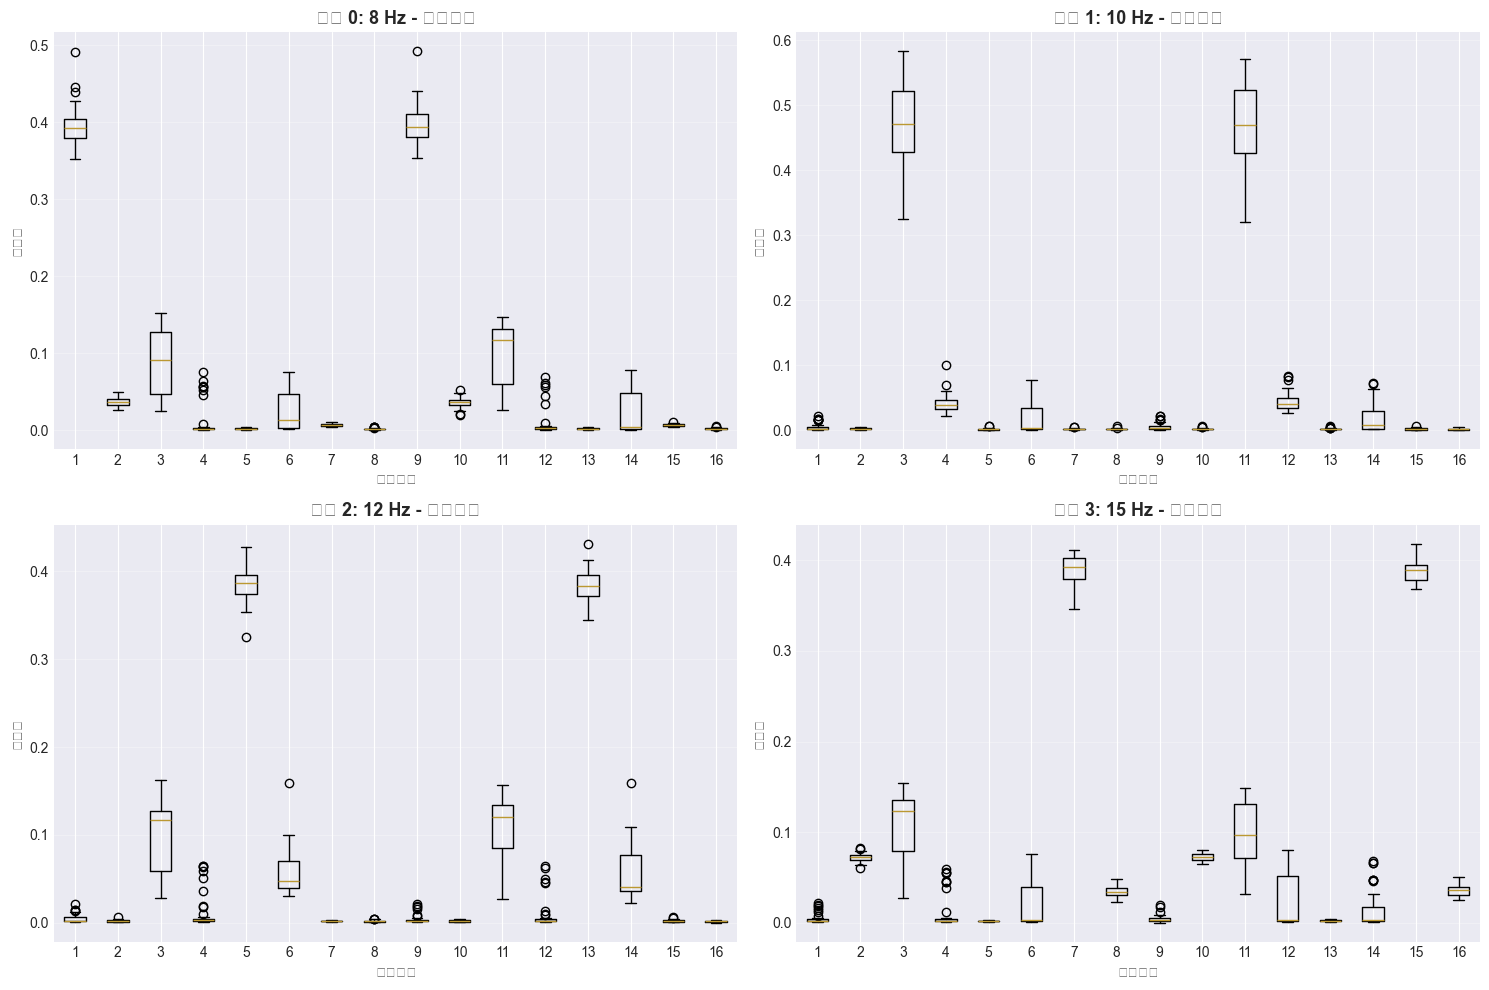

In [13]:
# 視覺化特徵分布
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for class_idx, freq in enumerate(target_freqs):
    # 取得該類別的所有特徵
    class_features = X_features[y_labels == class_idx]
    
    # 繪製前16個特徵的分布
    axes[class_idx].boxplot(class_features[:, :16], labels=range(1, 17))
    axes[class_idx].set_title(f'類別 {class_idx}: {freq} Hz - 特徵分布', 
                             fontsize=13, fontweight='bold')
    axes[class_idx].set_xlabel('特徵編號')
    axes[class_idx].set_ylabel('特徵值')
    axes[class_idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 6. 分類模型

我們使用多種分類器來辨識SSVEP頻率

In [14]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 分割訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_labels, test_size=0.3, random_state=42, stratify=y_labels
)

print(f"訓練集大小: {X_train.shape[0]} trials")
print(f"測試集大小: {X_test.shape[0]} trials")
print(f"\n訓練集標籤分布: {np.bincount(y_train)}")
print(f"測試集標籤分布: {np.bincount(y_test)}")

訓練集大小: 112 trials
測試集大小: 48 trials

訓練集標籤分布: [28 28 28 28]
測試集標籤分布: [12 12 12 12]


In [ ]:
# 訓練多個分類器
classifiers = {
    'SVM': SVC(kernel='rbf', C=1.0, gamma='scale'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'LDA': LinearDiscriminantAnalysis()
}

results = {}

print("開始訓練分類器...\n")

for name, clf in classifiers.items():
    print(f"訓練 {name}...")
    clf.fit(X_train, y_train)
    
    # 預測
    y_pred = clf.predict(X_test)
    
    # 計算準確率
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        'model': clf,
        'accuracy': accuracy,
        'predictions': y_pred
    }
    
    print(f"  ✅ {name} 準確率: {accuracy*100:.2f}%\n")

print("\n" + "="*50)
print("分類器性能比較:")
print("="*50)
for name, result in sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True):
    print(f"{name:20s}: {result['accuracy']*100:6.2f}%")

🔄 開始訓練分類器...

訓練 SVM...
  ✅ SVM 準確率: 100.00%

訓練 Random Forest...
  ✅ Random Forest 準確率: 100.00%

訓練 KNN...
  ✅ KNN 準確率: 100.00%

訓練 LDA...
  ✅ LDA 準確率: 100.00%


📊 分類器性能比較:
SVM                 : 100.00%
Random Forest       : 100.00%
KNN                 : 100.00%
LDA                 : 100.00%


## 7. 結果評估與視覺化

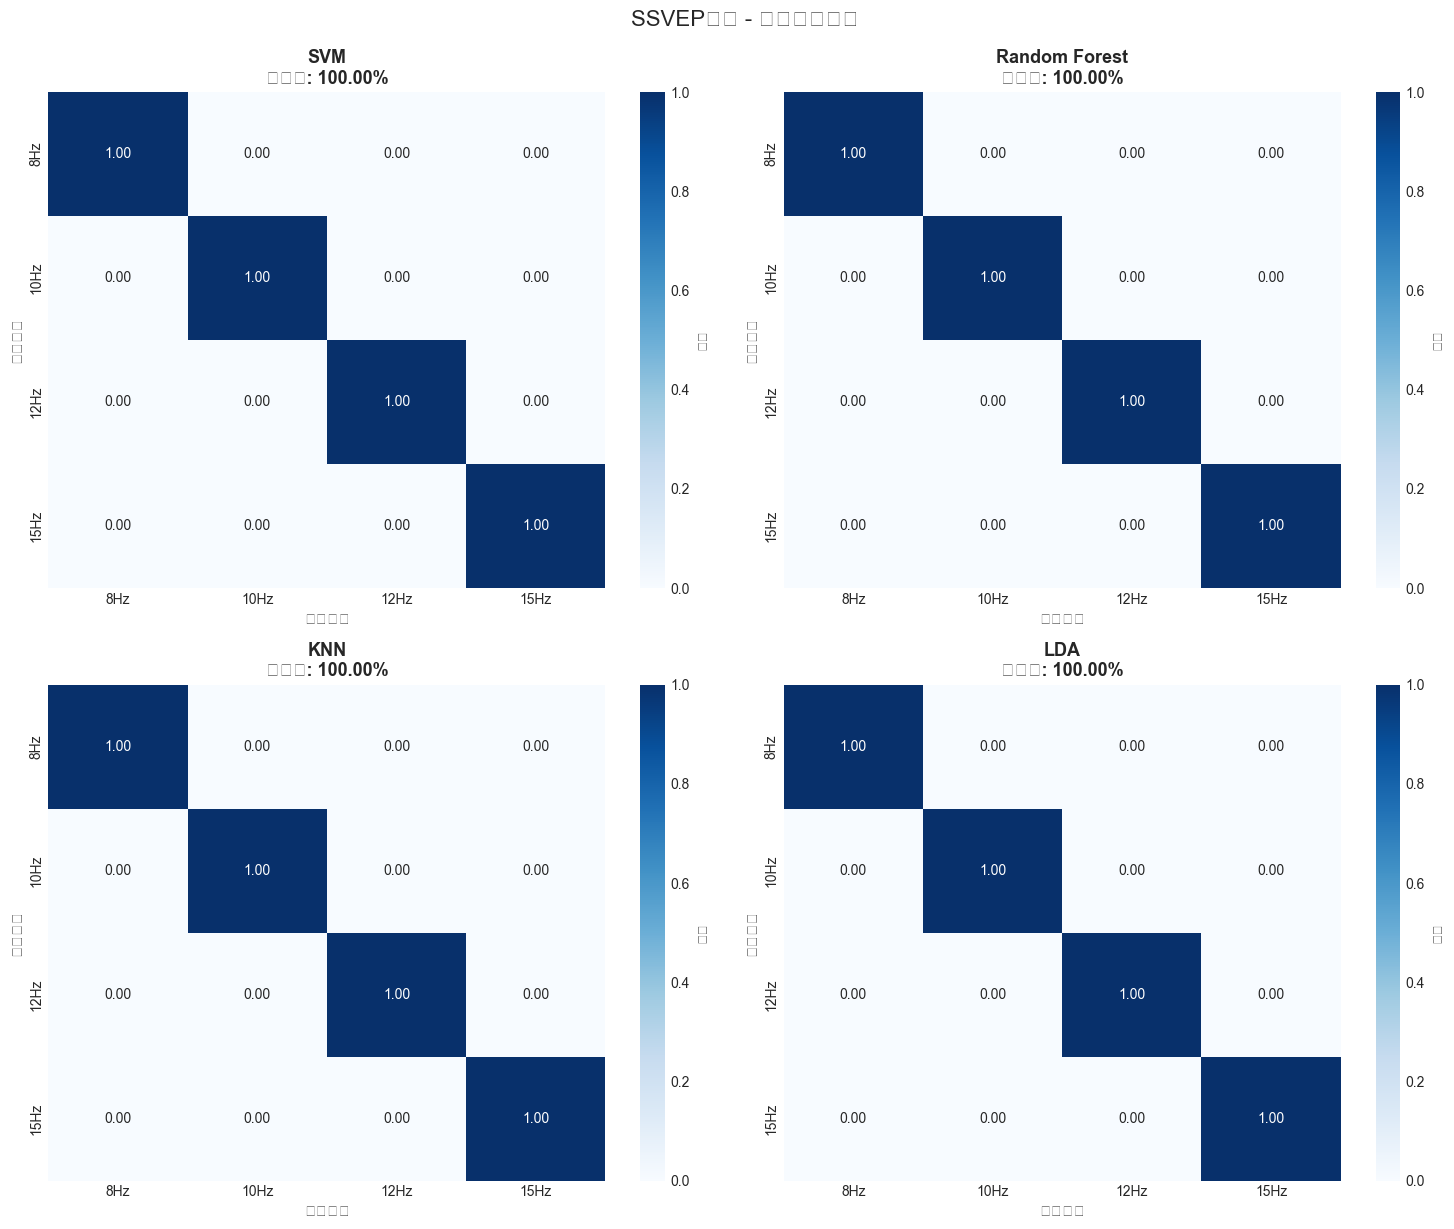

In [16]:
# 繪製所有分類器的混淆矩陣
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

class_names = [f'{freq}Hz' for freq in target_freqs]

for idx, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['predictions'])
    
    # 正規化到0-1
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # 繪製熱圖
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[idx], cbar_kws={'label': '比例'})
    
    axes[idx].set_title(f'{name}\n準確率: {result["accuracy"]*100:.2f}%', 
                       fontsize=13, fontweight='bold')
    axes[idx].set_ylabel('真實標籤', fontsize=11)
    axes[idx].set_xlabel('預測標籤', fontsize=11)

plt.tight_layout()
plt.suptitle('SSVEP分類 - 混淆矩陣比較', fontsize=16, y=1.02)
plt.show()

In [17]:
# 最佳模型的詳細報告
best_model_name = max(results.items(), key=lambda x: x[1]['accuracy'])[0]
best_predictions = results[best_model_name]['predictions']

print(f"\n{'='*60}")
print(f"最佳模型: {best_model_name}")
print(f"{'='*60}\n")

print(classification_report(y_test, best_predictions, 
                          target_names=class_names,
                          digits=4))


最佳模型: SVM

              precision    recall  f1-score   support

         8Hz     1.0000    1.0000    1.0000        12
        10Hz     1.0000    1.0000    1.0000        12
        12Hz     1.0000    1.0000    1.0000        12
        15Hz     1.0000    1.0000    1.0000        12

    accuracy                         1.0000        48
   macro avg     1.0000    1.0000    1.0000        48
weighted avg     1.0000    1.0000    1.0000        48



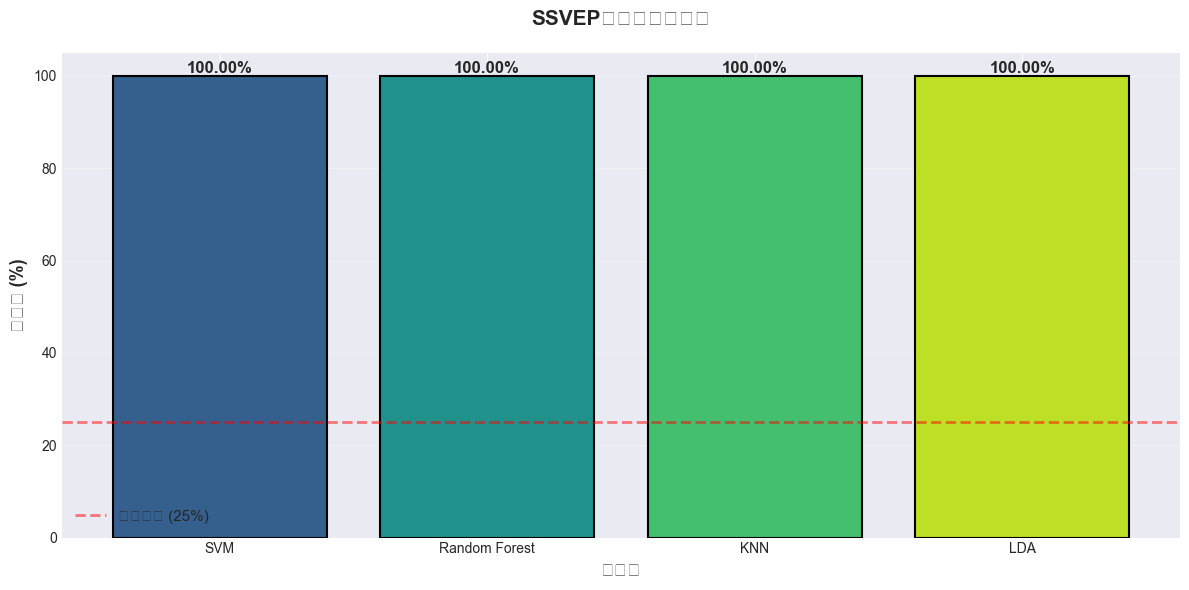

In [18]:
# 準確率比較圖
fig, ax = plt.subplots(figsize=(12, 6))

model_names = list(results.keys())
accuracies = [results[name]['accuracy'] * 100 for name in model_names]

colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(model_names)))
bars = ax.bar(model_names, accuracies, color=colors, edgecolor='black', linewidth=1.5)

# 在柱狀圖上顯示數值
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.2f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('準確率 (%)', fontsize=13, fontweight='bold')
ax.set_xlabel('分類器', fontsize=13, fontweight='bold')
ax.set_title('SSVEP分類器性能比較', fontsize=15, fontweight='bold', pad=20)
ax.set_ylim([0, 105])
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=25, color='red', linestyle='--', linewidth=2, alpha=0.5, 
          label='隨機猜測 (25%)')
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

## 8. 總結

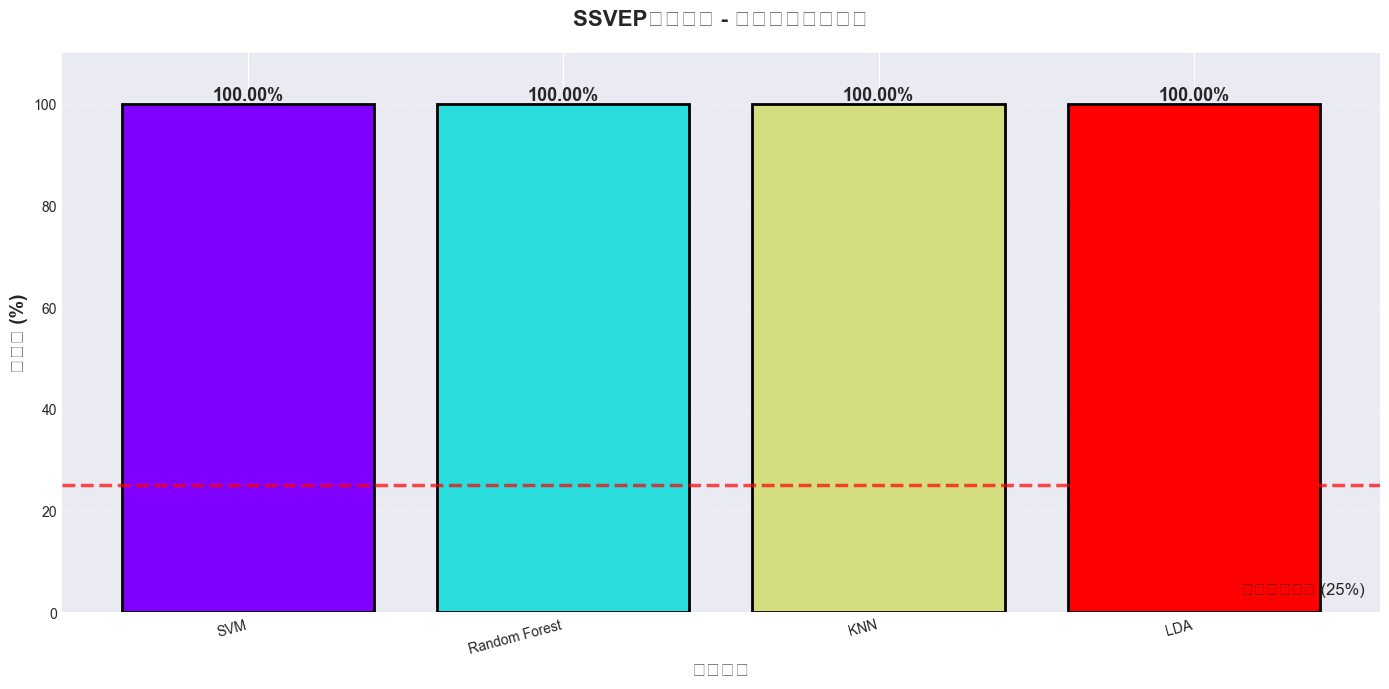


🏆 SSVEP分類方法排名
1. SVM                 : 100.00%
2. Random Forest       : 100.00%
3. KNN                 : 100.00%
4. LDA                 : 100.00%


In [ ]:

# 所有方法的總比較
all_results = results.copy()
'''
all_results['CCA'] = {
    'accuracy': cca_accuracy,
    'predictions': cca_predictions
}
'''

# 繪製總比較圖
fig, ax = plt.subplots(figsize=(14, 7))

method_names = list(all_results.keys())
accuracies = [all_results[name]['accuracy'] * 100 for name in method_names]

colors = plt.cm.rainbow(np.linspace(0, 1, len(method_names)))
bars = ax.bar(method_names, accuracies, color=colors, edgecolor='black', linewidth=2)

# 顯示數值
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.2f}%',
            ha='center', va='bottom', fontsize=13, fontweight='bold')

ax.set_ylabel('準確率 (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('分類方法', fontsize=14, fontweight='bold')
ax.set_title('SSVEP腦波分類 - 所有方法性能比較', fontsize=16, fontweight='bold', pad=20)
ax.set_ylim([0, 110])
ax.grid(True, alpha=0.3, axis='y', linestyle='--')
ax.axhline(y=25, color='red', linestyle='--', linewidth=2.5, alpha=0.7, 
          label='隨機猜測基線 (25%)')
ax.legend(fontsize=12, loc='lower right')

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("SSVEP分類方法排名")
print("="*70)
for i, (name, acc) in enumerate(sorted(zip(method_names, accuracies), 
                                       key=lambda x: x[1], reverse=True), 1):
    print(f"{i}. {name:20s}: {acc:6.2f}%")
print("="*70)

## 課程總結

### 我們學到了什麼？

1. **SSVEP原理**: 大腦視覺皮層對特定頻率閃爍光的反應

2. **完整Pipeline**:
   - 數據採集與視覺化
   - 訊號預處理（濾波、標準化）
   - 特徵提取（功率譜密度）
   - 分類器訓練與評估

3. **多種分類方法**:
   - SVM, Random Forest, KNN, LDA

4. **性能評估**: 混淆矩陣、準確率、分類報告

### 實際應用
- 腦機介面 (BCI)
- 輔助溝通系統
- 遊戲控制
- 醫療復健

### 延伸學習
- 嘗試使用真實EEG數據集
- 探索深度學習方法 (CNN, LSTM)
- 優化特徵提取方法
- 實時SSVEP系統開發

---

##  參考資源
- MNE-Python: https://mne.tools/
- 公開數據集: BETA dataset, Benchmark dataset
- 相關論文: IEEE Transactions on Biomedical Engineering


## 互動練習區

In [20]:
# 練習1: 改變訊噪比，觀察對分類性能的影響
# 提示: 修改 generate_ssvep_signal 函數中的 snr 參數

# 練習2: 嘗試增加更多目標頻率 (例如: 6Hz, 14Hz)
# 提示: 修改 target_freqs 列表

# 練習3: 調整濾波器參數，看看效果如何
# 提示: 修改 preprocess_signal 中的 lowcut 和 highcut

# 練習4: 嘗試其他特徵提取方法
# 提示: 可以加入時域特徵，如均值、變異數等

print("請在上面的code cells中嘗試修改參數，觀察結果變化！")

請在上面的code cells中嘗試修改參數，觀察結果變化！
